<a href="https://colab.research.google.com/github/ITZ-NANO21-MC/API-de-Gesti-n-de-Tareas/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [53]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
Batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2025-06-16 15:29:42--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.5’

cats_and_dogs.zip.5 100%[===================>]  67.43M   173MB/s    in 0.4s    

2025-06-16 15:29:43 (173 MB/s) - ‘cats_and_dogs.zip.5’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [54]:
# 3
# Generadores
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Configuración de flujos
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=Batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=Batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,  # Directorio padre
    classes=['test'],  # Subdirectorio con imágenes
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=Batch_size,
    class_mode=None,  # Para predicción
    shuffle=False
)

# Verificación
print(f"Imágenes de entrenamiento: {train_data_gen.samples}")
print(f"Imágenes de validación: {val_data_gen.samples}")
print(f"Imágenes de prueba: {test_data_gen.samples}")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
Imágenes de entrenamiento: 2000
Imágenes de validación: 1000
Imágenes de prueba: 50


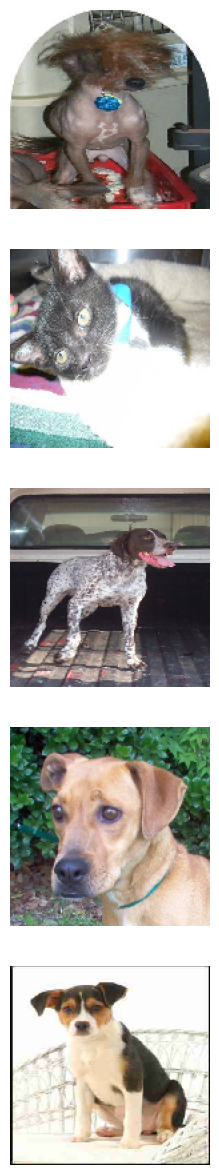

In [55]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [56]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,  # Normalización de valores de píxeles (0-1)
    rotation_range=40,  # Rotación aleatoria hasta 40 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio (20% del ancho)
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio (20% del alto)
    shear_range=0.2,  # Deformación de corte aleatoria
    zoom_range=0.2,  # Zoom aleatorio hasta 20%
    horizontal_flip=True,  # Volteo horizontal aleatorio
    fill_mode='nearest'  # Estrategia para llenar puntos creados por transformaciones
)

Found 2000 images belonging to 2 classes.


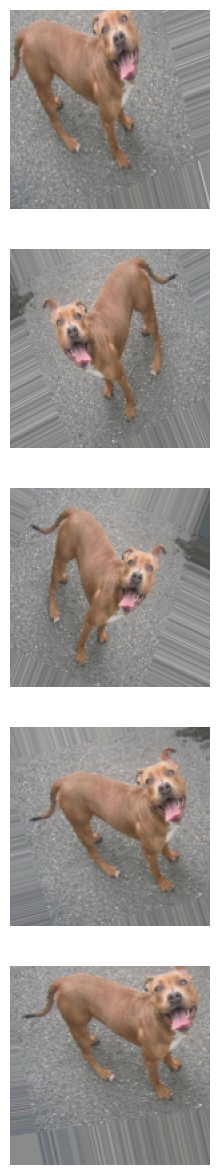

In [57]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=Batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [58]:
# 7
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8
history = model.fit(
    x=train_data_gen,  # Generador de datos de entrenamiento
    steps_per_epoch=train_data_gen.samples // Batch_size,  # Número de batches por época
    epochs=epochs,  # Número de épocas de entrenamiento
    validation_data=val_data_gen,  # Generador de datos de validación
    validation_steps=val_data_gen.samples // Batch_size  # Batches de validación
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.4994 - loss: 1.6477 - val_accuracy: 0.4978 - val_loss: 1.5496
Epoch 2/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.5469 - loss: 1.5458

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 688ms/step - accuracy: 0.5469 - loss: 1.5458 - val_accuracy: 0.5167 - val_loss: 1.5404
Epoch 3/20
11/15 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.5265 - loss: 1.5194

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 11

# Primero verifica que el generador de prueba esté configurado correctamente
print(f"Número de imágenes de prueba encontradas: {test_data_gen.samples}")

if test_data_gen.samples > 0:
    # Reiniciar el generador para empezar desde el principio
    test_data_gen.reset()

    # Obtener predicciones para todas las imágenes de prueba
    probabilities = model.predict(
        test_data_gen,  # Pasar el generador, no .samples
        steps=(test_data_gen.samples // Batch_size) + 1
    ).flatten()

    # Asegurarse de tomar solo las primeras 50 predicciones
    probabilities = probabilities[:50]

    # Respuestas correctas
    answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
              1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
              1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
              1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
              0, 0, 0, 0, 0, 0]

    # Calcular precisión
    correct = 0
    for probability, answer in zip(probabilities, answers):
        if round(probability) == answer:
            correct += 1

    percentage_identified = (correct / len(answers)) * 100
    passed_challenge = percentage_identified >= 63

    print(f"Tu modelo identificó correctamente el {round(percentage_identified, 2)}% de las imágenes.")

    if passed_challenge:
        print("¡Pasaste el desafío!")
    else:
        print("Aún no pasaste. Tu modelo debe identificar al menos el 63% de las imágenes.")
else:
    print("Error: No se encontraron imágenes de prueba. Verifica la configuración del directorio.")